In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal as deci
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor as rfr
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = [10,8]

In [3]:
cf=rfr(n_estimators = 5, n_jobs=-1,verbose=1)

In [3]:
zspectra = pd.read_csv('fitted_cest.csv', header = None).values.squeeze()
diff = pd.read_csv('diff.csv', header = None).values.squeeze()
conc = pd.read_csv('conc.csv', header = None).values.squeeze()
pH = pd.read_csv('pH.csv', header = None).values.squeeze()
concs = pd.read_csv('concs.csv', header = None).values.squeeze()
pHs = pd.read_csv('pHs.csv', header = None).values.squeeze()

In [4]:
def mymetric(yexp, ypred):
    yexp=yexp.squeeze()
    ypred=ypred.squeeze()
    d = np.sqrt(mean_squared_error(yexp, ypred))
    d = d / np.mean(yexp)
    d = 100 * d
    return d

In [5]:
def mystddev(yexp,ypred):
    sy=np.std(ypred)
    d = np.sum(yexp - ypred) / np.sqrt(np.sum((yexp - ypred)**2 ))
    d = d / np.sqrt(ypred.shape[0])
    d = d / np.mean(yexp)
    d = 100 * d
    sd=np.sqrt(np.square(d)*np.square(sy))
    return sd

In [6]:
X = diff
Y = pH
Ys = np.sort(pHs)

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.05, random_state=42)
cf.fit(X_train,y_train)
y_hat=cf.predict(X_test)
mymetric(y_test,y_hat)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


1.5945805227624485

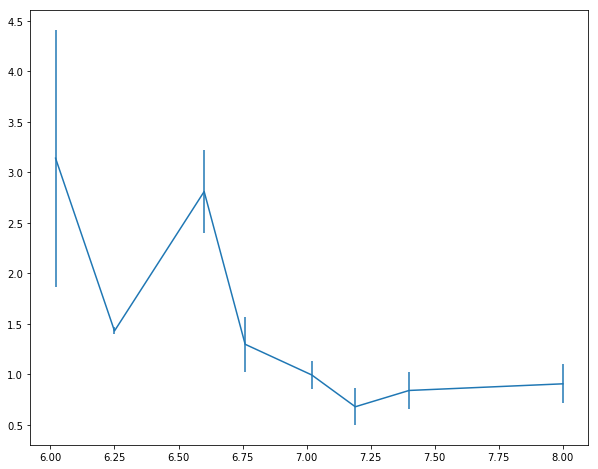

In [8]:
Error_dum = np.zeros(Ys.shape)
Error_std = np.zeros(Ys.shape)
for idk,K in enumerate(np.arange(0,Ys.shape[0])):
    Error_dum[K] = mymetric(y_test[np.where(y_test==(np.ones(y_test.shape)*Ys[K]))], y_hat[np.where(y_test==(np.ones(y_test.shape)*Ys[K]))])
    Error_std[K] = mystddev(y_test[np.where(y_test==(np.ones(y_test.shape)*Ys[K]))], y_hat[np.where(y_test==(np.ones(y_test.shape)*Ys[K]))])
    
plt.errorbar(Ys,Error_dum, yerr = Error_std);

NRMSE for all voxels, all pHs w/ lin regr:  8.00222219311 %


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_j

NRMSE for all voxels, all pHs w/ random trees:  4.38699267774 %


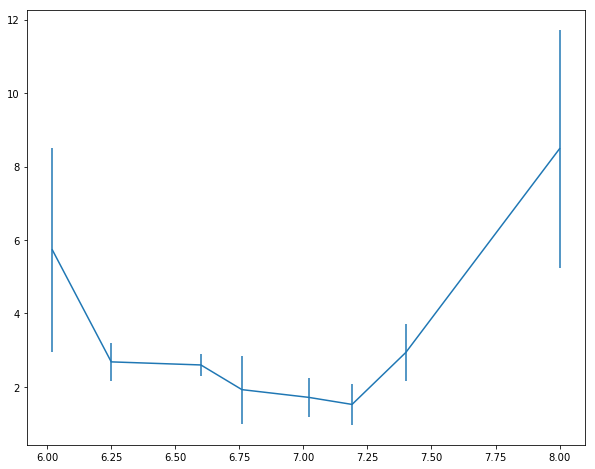

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

perc_hold_out = 10#%
y_hat_lin = cross_val_predict(regressor,X,Y, cv=round(100//perc_hold_out))
print('NRMSE for all voxels, all pHs w/ lin regr: ',mymetric(Y,y_hat_lin),'%')

perc_hold_out = 10#%
y_hat = cross_val_predict(cf,X,Y, cv=round(100//perc_hold_out))
print('NRMSE for all voxels, all pHs w/ random trees: ',mymetric(Y,y_hat),'%')

Error_dum = np.zeros(Ys.shape)
Error_std = np.zeros(Ys.shape)
for idk,K in enumerate(np.arange(0,Ys.shape[0])):
    Error_dum[K] = mymetric(Y[np.where(Y==(np.ones(Y.shape)*Ys[K]))], y_hat[np.where(Y==(np.ones(Y.shape)*Ys[K]))])
    Error_std[K] = mystddev(Y[np.where(Y==(np.ones(Y.shape)*Ys[K]))], y_hat[np.where(Y==(np.ones(Y.shape)*Ys[K]))])
    
plt.errorbar(Ys,Error_dum, yerr = Error_std);

In [10]:
np.savetxt('NRMSE_oxi_rf.csv',Error_dum,delimiter=',')

In [11]:
'''plt.rc('font',size=24)
plt.scatter(Y,y_hat,c=conc);
plt.colorbar();
plt.hold;
plt.plot(pHs,pHs,'--',lw = 4);
plt.ylabel('Predicted pH');
plt.ylim((5,9))
plt.xlabel('Measured pH');
plt.savefig('pred_vs_meas_oxi_rf.tif',dpi = 300, format='tif')'''

"plt.rc('font',size=24)\nplt.scatter(Y,y_hat,c=conc);\nplt.colorbar();\nplt.hold;\nplt.plot(pHs,pHs,'--',lw = 4);\nplt.ylabel('Predicted pH');\nplt.ylim((5,9))\nplt.xlabel('Measured pH');\nplt.savefig('pred_vs_meas_oxi_rf.tif',dpi = 300, format='tif')"

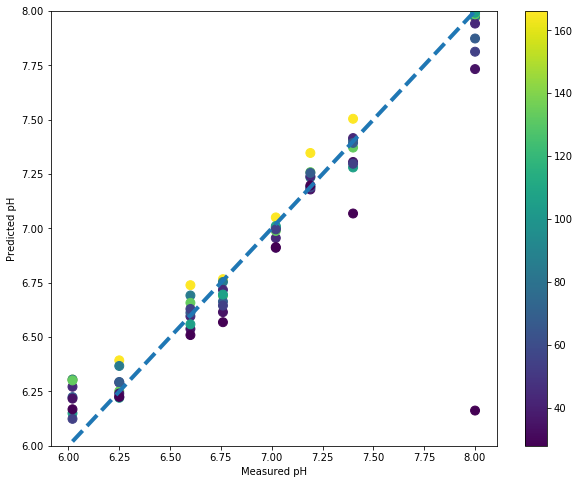

In [12]:
Error_dum = np.zeros((72,1))
pH_plt = np.zeros((72,1))
c_plt = np.zeros((72,1))
last_n = 0
for idk,p in enumerate(np.arange(0,Ys.shape[0])):
    for i,c in enumerate(np.arange(0,concs.shape[0])):
        y_plot = y_hat[Y==Ys[p]];
        y_plot = y_plot[conc[Y==Ys[p]]==concs[c]]
        Error_dum[c+last_n] = np.mean(y_plot)
        pH_plt[c+last_n] = Ys[p];
        c_plt[c+last_n] = concs[c];
    last_n=last_n+9;

fig = plt.figure();
ax = fig.add_subplot(1,1,1);
plt.scatter(pH_plt,Error_dum,c=c_plt,s=80);
plt.colorbar();
plt.plot(pHs,pHs,'--',lw = 4);
plt.ylabel('Predicted pH');
plt.ylim((6,8))
plt.xlabel('Measured pH');

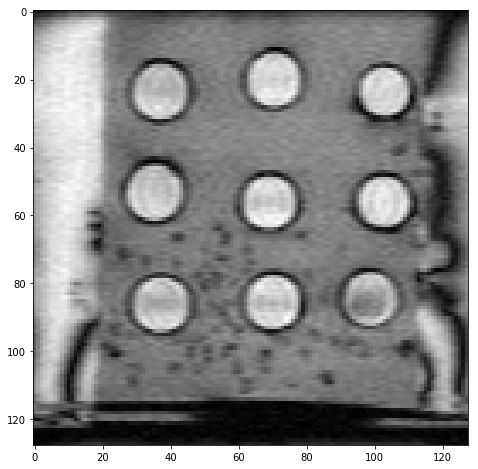

In [13]:
import BrukerMRI as bruker

img_pH = 7.40
d = str(deci(str(img_pH)).quantize(deci('10')**-2))
i = np.where(pHs==img_pH)

mainDir = './Images/pH'+d+'/'
expNum = 1 # 1 = CEST, 2 = T2, 3 = T1 if available
expObj = bruker.ReadExperiment(mainDir, expNum)
cest_img_set = np.flipud(expObj.proc_data)
anatomical = cest_img_set[:,:,0]

plt.imshow(anatomical);
plt.set_cmap('gray');

masks = pd.read_csv('mask.csv', header = None).values.squeeze()
masks = masks.reshape((128,8,128))

indices = np.nonzero(masks[:,i,:].squeeze().reshape((1,-1)))[1]
pH_mask = np.zeros((1,128*128))

In [14]:
Y_hat = y_hat[np.where(Y==Ys[i])]

In [15]:
pH_mask[0,indices]=Y_hat
pH_mask = pH_mask.reshape((128,128))

In [16]:
pH_masked = np.ma.masked_where(pH_mask==0,pH_mask)

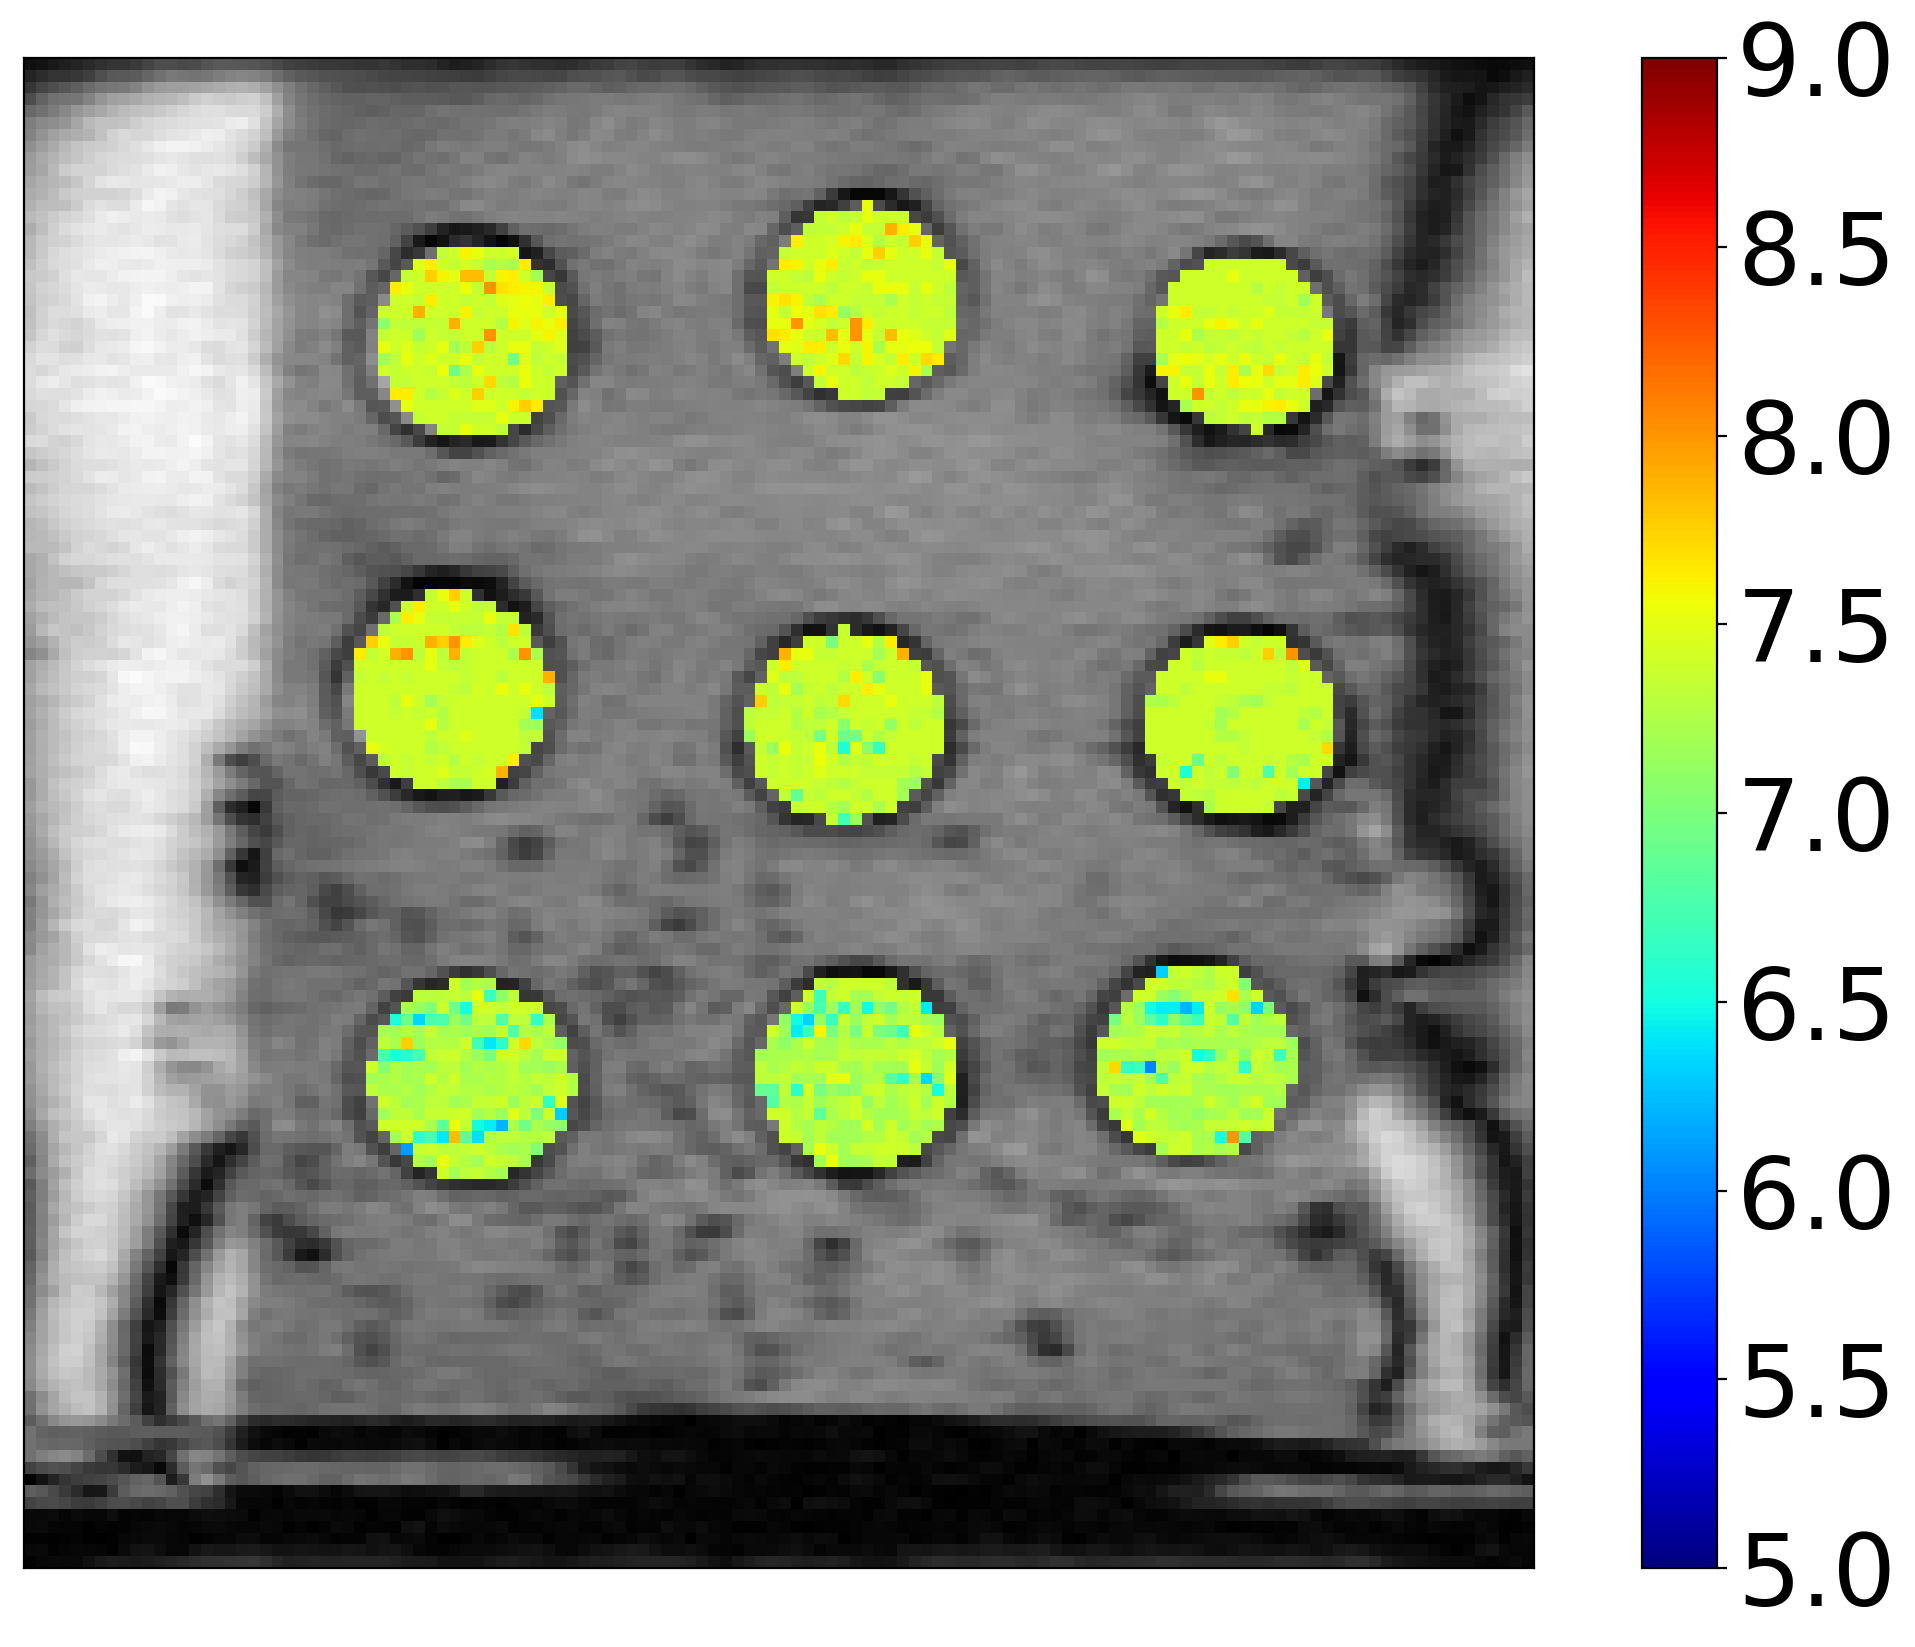

In [17]:
plt.rc('font',size=36)
plt.figure(figsize=(14, 10), dpi= 200, facecolor='w', edgecolor='k');
plt.imshow(anatomical);
plt.set_cmap('gray');
plt.hold;
plt.imshow(pH_masked, vmin=5, vmax = 9);
plt.set_cmap('jet');
plt.colorbar();
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off', # ticks along the top edge are off
    left='off',
    labelbottom='off', labelleft='off'); # labels along the bottom edge are off
plt.savefig('pHmap_oxi_rf.tif',dpi = 300, format='tif')

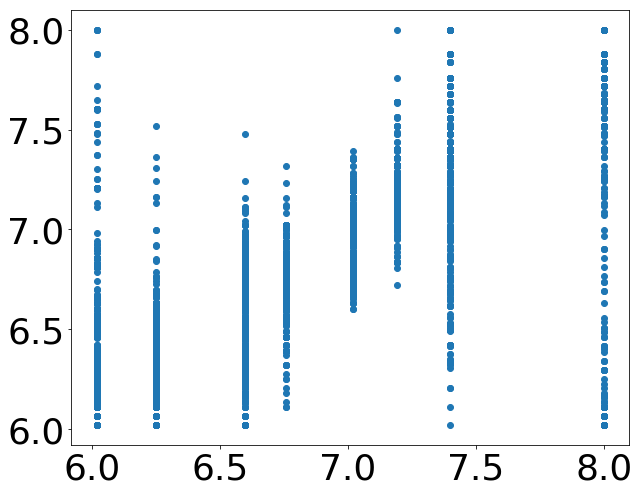

In [18]:
plt.plot(Y,y_hat,'o')